Some preliminaries

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [89]:
import numpy as np
from scipy.integrate import trapz, quad, cumtrapz
from astropy import cosmology
from astropy import constants

The astropy cosmology module has some built-in cosmologies, for example Planck15, or WMAP9

In [17]:
Planck = cosmology.Planck15
WMAP = cosmology.WMAP9
print(Planck)
print(WMAP)

FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)
FlatLambdaCDM(name="WMAP9", H0=69.3 km / (Mpc s), Om0=0.286, Tcmb0=2.725 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=0.0463)


You can also define your own FLRW cosmology:

In [23]:
flatcosmo = cosmology.FlatLambdaCDM(Om0 = 0.3, H0=70)
print('In my flat cosmology, Omega_Lambda,0=%.2f. Omega_Lambda,0 + Omega_m,0 = %.2f.' %(flatcosmo.Ode0, flatcosmo.Ode0+flatcosmo.Om0))

In my flat cosmology, Omega_Lambda,0=0.70. Omega_Lambda,0 + Omega_m,0 = 1.00.


In [29]:
curvedcosmo = cosmology.LambdaCDM(Om0 = 0.3, Ode0 = 0.1, H0=70)
print('In my non-flat cosmology, Omega_k,0 = %.2f. Omega_k,0 + Omega_m,0 + Omega_Lambda,0 = %.2f.' %(curvedcosmo.Ok0, curvedcosmo.Ode0+curvedcosmo.Om0+curvedcosmo.Ok0))

In my non-flat cosmology, Omega_k,0 = 0.60. Omega_k,0 + Omega_m,0 + Omega_Lambda,0 = 1.00.


Astropy has functions to compute various distance measures as a function of redshift

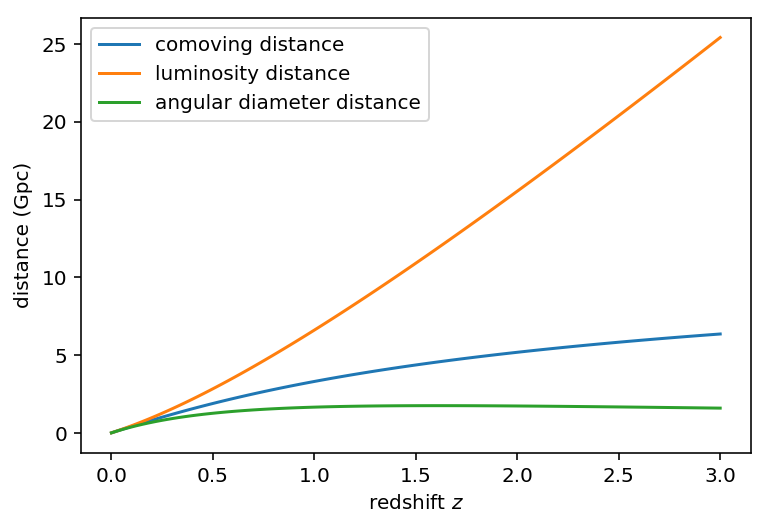

In [95]:
zs = np.linspace(0.,3.,100)
dLs = flatcosmo.luminosity_distance(zs).to('Gpc').value
dAs = flatcosmo.angular_diameter_distance(zs).to('Gpc').value
dCs = flatcosmo.comoving_distance(zs).to('Gpc').value
plot(zs,dCs,label='comoving distance')
plot(zs,dLs,label='luminosity distance')
plot(zs,dAs,label='angular diameter distance')
dLs = curvedcosmo.luminosity_distance(zs).to('Gpc').value
xlabel(r'redshift $z$')
ylabel('distance (Gpc)')
legend(loc='best')
show()

Notice how the angular diameter distance is not monotnically increasing as a function of redshift, but peaks between $1 < z < 2$

In [46]:
zs[argmax(dAs)]

1.6060606060606062

Also note that astropy handles units pretty conveniently:

In [58]:
print('The luminosity distance at z = 1.0 in my flat cosmology is: ', flatcosmo.luminosity_distance(1.0))
print('The luminosity distance at z = 1.0 in my flat cosmology is: ', flatcosmo.luminosity_distance(1.0).to('AU'))
print('The luminosity distance at z = 1.0 in my curved cosmology is: ', curvedcosmo.luminosity_distance(1.0))

The luminosity distance at z = 1.0 in my flat cosmology is:  6607.657611774937 Mpc
The luminosity distance at z = 1.0 in my flat cosmology is:  1362927217029230.8 AU
The luminosity distance at z = 1.0 in my curved cosmology is:  5958.691894429425 Mpc


We can write our own functions to calculate these distances using calls to scipy.integrate functions. Astropy uses scipy.integrate.quad for its integrals. scipy.integrate.quad uses various numerical integration (numerical quadrature) techniques. We'll talk about some simple ones.

In [80]:
c = constants.c.to('km/s').value #speed of light in km/s

def Ez(z,Om0,Ode0):
    Ok0 = 1.0-Om0-Ode0
    zp1 = 1.0+z
    return sqrt(Om0*(zp1)**3+Ok0*(zp1)**2+Ode0)

def comoving_distance(z, Om0, Ode0, H0):
    try:
        out = array([c/H0*quad(lambda x: 1.0/Ez(x,Om0,Ode0),0.0,zi)[0] for zi in z])
    except TypeError:
        out = c/H0*quad(lambda x: 1.0/Ez(x,Om0,Ode0),0.0,z)[0]
    return out


def luminosity_distance(z,Om0,Ode0,H0):
    return (1.0+z)*comoving_distance(z,Om0,Ode0,H0)

print(comoving_distance(1.0,0.3,0.7,70.0))
print(flatcosmo.comoving_distance(1.0))

3303.8288058874678
3303.8288058874687 Mpc


A basic integration method is trapezoidal integration:

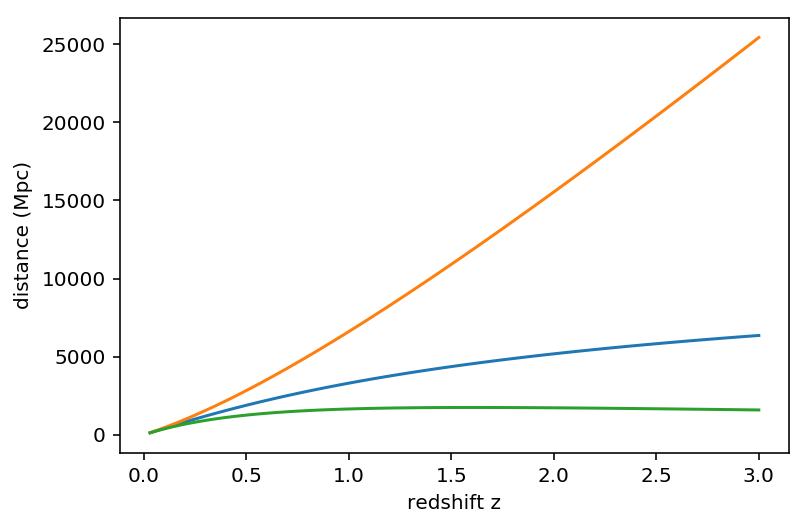

In [94]:
def comoving_distance(zfin, Om0, Ode0, H0):
    zs = linspace(0.0,zfin,100)
    Dcs = cumtrapz(c/H0*1.0/Ez(zs,Om0,Ode0),zs)
    return Dcs, zs[1:]

def luminosity_distance(zfin, Om0, Ode0, H0):
    Dcs, zs = comoving_distance(zfin, Om0, Ode0, H0)
    DLs = Dcs * (1.0+zs)
    return DLs, zs

def angular_diameter_distance(zfin,Om0,Ode0,H0):
    Dcs, zs = comoving_distance(zfin,Om0, Ode0, H0)
    DAs = Dcs / (1.0+zs)
    return DAs, zs

Dcs, zs = comoving_distance(3.0,0.3,0.7,70.0)
DLs, zs = luminosity_distance(3.0,0.3,0.7,70.0)
DAs, zs = angular_diameter_distance(3.0,0.3,0.7,70.0)

plot(zs,Dcs,label = 'comoving distance')
plot(zs,DLs, label = 'luminosity distance')
plot(zs,DAs, label = 'angular diameter distance')
ylabel('distance (Mpc)')
xlabel('redshift z')
show()